In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
import os
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, Conv2D, Flatten, MaxPooling2D, AveragePooling2D, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow import clip_by_value
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
import pickle
from random import sample
import gc

The facial expression data is provided by Kaggle in .csv format, where each row represents an image, columns 1 and 2 denote the training/test set and emotion label respectively, and the remaining columns represent the grayscale value between 1 and 255 representing the pixel color.  Below I specify the dimension for the image (48x48), and subsequently load and visualize a sample of 25 images from the dataset.

In [2]:
pic_size = 48

In [3]:
img_path = 'C:\\Users\\rbush\\Documents\\Machine Learning\\Pictures\\Facial Expressions'

In [4]:
df = pd.read_csv(img_path+'\\icml_face_data.csv', header=None)

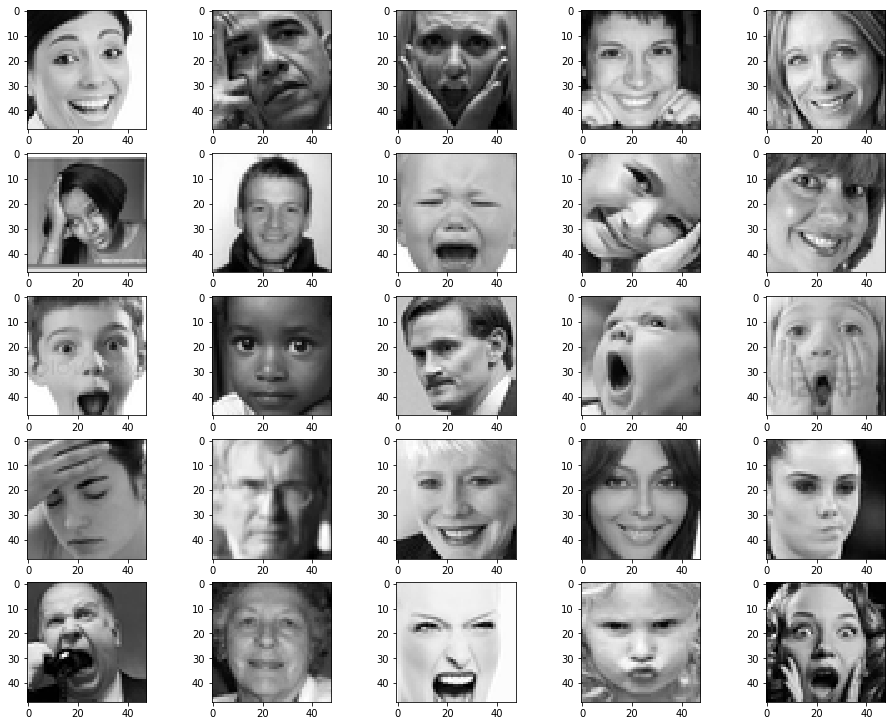

In [5]:
sample_df = df.sample(25)
center = 0
i = 0
pl.figure(0, figsize=(16,18))
for row in range(5):
    for col in range(5):
        center += 1
        pl.subplot(7,5,center)
        img = array_to_img(np.array(sample_df.iloc[i,2:2306]).reshape(48,48,1))
        pl.imshow(img, cmap='gray')
        i += 1
pl.show()

In the competition, there are three datasets: **Training, PublicTest,** and **PrivateTest**.  When the competition went live, Training and PublicTest were made available for model development.  PrivateTest was the dataset used by Kaggle to evaluate each submission on unseen data.

The first step I took in the development of my models was to use Scikit-Learn's MinMaxScaler to scale all of the pixel values between 0 and 1 for efficient neural network optimization.  I stored the resulting train, test, and validation sets as Parquet files for quick data loads during model training.  Below I show how I indexed the datasets for clarity, and in the next cell load my Parquet-format dataset from memory.

In [6]:
train_images = df.loc[df[1]=='Training'].iloc[:,2:2306]
test_images = df.loc[df[1]=='PublicTest'].iloc[:,2:2306]
val_images = df.loc[df[1]=='PrivateTest'].iloc[:,2:2306]

train_labels = to_categorical(df.loc[df[1]=='Training'][0])
test_labels = to_categorical(df.loc[df[1]=='PublicTest'][0])
val_labels = to_categorical(df.loc[df[1]=='PrivateTest'][0])

In [7]:
train_images = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Images\\train_images.parquet').read().to_pandas()
test_images = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Images\\test_images.parquet').read().to_pandas()
val_images = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Images\\val_images.parquet').read().to_pandas()

train_labels = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Labels\\train_labels.parquet').read().to_pandas()
test_labels = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Labels\\test_labels.parquet').read().to_pandas()
val_labels = pq.ParquetDataset('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Training Data\\Labels\\val_labels.parquet').read().to_pandas()

The image files contain only pixel values (48 * 48 = 2304), and the label records for each emotion have been converted into one-hot encodings.  When the models are trained, I used a softmax output layer and trained with a categorical crossentropy loss function.

In [8]:
print(train_images.shape, test_images.shape, val_images.shape)

(28709, 2304) (3589, 2304) (3589, 2304)


In [9]:
print(train_labels.shape, test_labels.shape, val_labels.shape)

(28709, 7) (3589, 7) (3589, 7)


I tested a few different neural network architectures for this competition:

- Dense
- Convolutional
- Convolutional with tuned hyperparameters
- ResNet50V2

I began with a Dense network to see how a fully-connected approach would perform on the dataset.  Then I experimented with a number of custom Convolutional architectures and ultimately landed on one I found to be most effective.  I tested several hyperparameter combinations, picked one which showed the best combination of validation accuracy without overfitting, and trained that tuned Convolutional model with those hyperparameters.  For fun, I also tested the ResNet50V2 model from the Keras library to see how it would perform on a much simpler image dataset than the one it was designed for.  

Below I've loaded the training history for each of these models and plotted them by epoch.

In [10]:
training_history_files = {'dense':'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Models\\Dense\\Training History.pkl',
                          'convolutional':'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Models\\Convolutional_Max Pooling_Increased Convolutions\\Training History.pkl',
                          'resnet':'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Models\\ResNet50V2\\Training History.pkl',
                          'tuned_hyperparams':'C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Models\\Convolutional_High Softmax Dropout\\Training History.pkl'
                          }

In [11]:
with open(training_history_files['dense'], 'rb') as infile:
    dense_history = pickle.load(infile)
    
with open(training_history_files['convolutional'], 'rb') as infile:
    conv_history = pickle.load(infile)

with open(training_history_files['resnet'], 'rb') as infile:
    resnet_history = pickle.load(infile)
    
with open(training_history_files['tuned_hyperparams'], 'rb') as infile:
    tuned_hyperparams = pickle.load(infile)

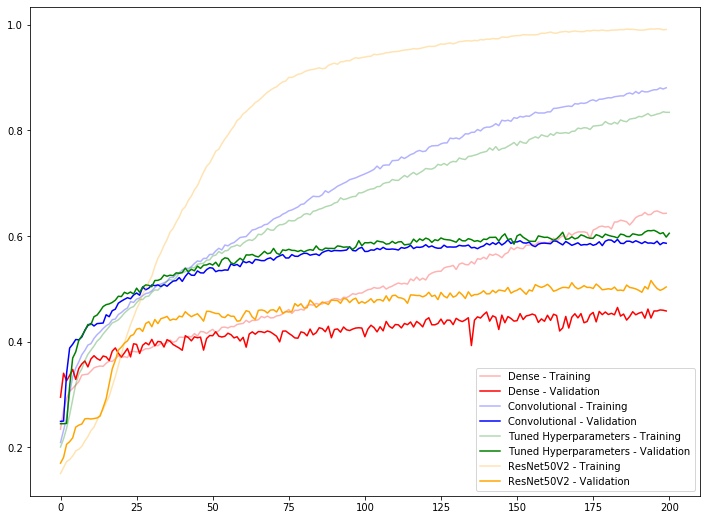

In [12]:
pl.figure(figsize=(12,9))
pl.plot(dense_history['accuracy'], color='red', alpha=0.3, label='Dense - Training')
pl.plot(dense_history['val_accuracy'], color='red', alpha=1, label='Dense - Validation')
pl.plot(conv_history['accuracy'], color='blue', alpha=0.3, label='Convolutional - Training')
pl.plot(conv_history['val_accuracy'], color='blue', alpha=1, label='Convolutional - Validation')
pl.plot(tuned_hyperparams['accuracy'][0:201], color='green', alpha=0.3, label='Tuned Hyperparameters - Training')
pl.plot(tuned_hyperparams['val_accuracy'][0:201], color='green', alpha=1, label='Tuned Hyperparameters - Validation')
pl.plot(resnet_history['accuracy'], color='orange', alpha=0.3, label='ResNet50V2 - Training')
pl.plot(resnet_history['val_accuracy'], color='orange', alpha=1, label='ResNet50V2 - Validation')
pl.legend()
pl.show()

In the plot above, a few things stand out:

- All of the models began to overfit on the image dataset quickly.  Regularization is a huge component of developing a high-performance model for this competition.
- The Dense network significantly underperforms each convolutional approach.  I'm sure this isn't surprising to anyone!
- The "simple" Convolutional approach performed the best, especially after some hyperparameter tuning.  While ResNet50V2 is a very powerful image recognition model, it has too much ability to fit the images it sees, and overfits rapidly on the competition dataset.

For my final model, I chose the Convolutional architecture with optimized hyperparameters.  Below for demonstration I've shown how the model is constructed.

In [13]:
# cnn_input = Input(shape=(48,48,1))
# x = Conv2D(224, kernel_size=6, activation=LeakyReLU(alpha=0.021))(cnn_input)
# x = MaxPooling2D(pool_size=(2,2))(x)
# x = Dropout(0.5)(x)
# x = Conv2D(448, kernel_size=2, activation=LeakyReLU(alpha=0.021))(x)
# x = MaxPooling2D(pool_size=(2,2))(x)
# x = Flatten()(x)
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.8)(x)
# cnn_output = Dense(7, activation='softmax')(x)

# cnn = Model(inputs=[cnn_input], outputs=cnn_output)
# optimizer = optimizers.Adam(learning_rate=0.000125)
# cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

I implemented an early-stopping/optimal weights callback and trained for 500 epochs.  Here I'm cheating a little bit by having it pick the best hyperparameters on the validation set, but I wanted to see how good the model could be with its current configuration.

In [14]:
# earlystop = EarlyStopping(monitor='val_accuracy', patience=50, min_delta=1e-4, restore_best_weights=True)

In [15]:
# cnn_history = cnn.fit(train_images, train_labels, validation_data=(val_images, val_labels),
#                       batch_size=200, epochs=500, callbacks=[earlystop])

To save you the ~700 lines of Keras training print statements, I've gone ahead and loaded my trained model from memory.  Below I generated predictions with the model on the validation images and plot the results in a confusion matrix.

In [16]:
cnn = keras.models.load_model('C:\\Users\\rbush\\Documents\\Projects\\Computer Vision\\Facial Expressions\\Models\\Convolutional_High Softmax Dropout\\Model.h5')

In [17]:
val_images = np.array(val_images).reshape(val_images.shape[0],pic_size,pic_size,1)

In [18]:
cnn_predicted_categories = np.argmax(cnn.predict(val_images), axis=1)
val_labels = np.argmax(np.array(val_labels), axis=1)

In [19]:
cnn_cm = confusion_matrix(cnn_predicted_categories, val_labels, labels=[0,1,2,3,4,5,6])
cnn_cm

array([[234,   9,  55,  22,  53,   4,  26],
       [  6,  25,   3,   0,   3,   0,   1],
       [ 45,   8, 240,  14,  64,  32,  25],
       [ 56,   2,  39, 746,  69,  24,  85],
       [ 70,   9,  86,  45, 277,   8,  94],
       [ 15,   1,  44,  18,  10, 329,   9],
       [ 65,   1,  61,  34, 118,  19, 386]], dtype=int64)

Overall the Model achieves 62.3% accuracy, which is quite good relative to the entries in the competition.  If I were to have submitted this a few years ago when it was live (and got a little lucky with my training iteration), this would have netted me a 10th place finish on the private leaderboard.  Not bad!

In [20]:
cnn_accuracy = (cnn_cm[0,0]+cnn_cm[1,1]+cnn_cm[2,2]+cnn_cm[3,3]+cnn_cm[4,4]+cnn_cm[5,5]+cnn_cm[6,6])/np.sum(cnn_cm)
print(f'Model Accuracy: {round(100*cnn_accuracy,1)}%')

Model Accuracy: 62.3%


In [21]:
correct_classifications = 0
individual_classification_dict = {0:[0,0],
                                  1:[0,0],
                                  2:[0,0],
                                  3:[0,0],
                                  4:[0,0],
                                  5:[0,0],
                                  6:[0,0]}
for pred in range(cnn_predicted_categories.shape[0]):        
    # If the correct classification is Angry, tally the observation and determine whether the model was correct
    if val_labels[pred] == 0:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Disgust, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 1:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Fear, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 2:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Happy, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 3:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Sad, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 4:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Surprise, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 5:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1
            
    # If the correct classification is Neutral, tally the observation and determine whether the model was correct        
    elif val_labels[pred] == 6:
        individual_classification_dict[val_labels[pred]][0] += 1
        if cnn_predicted_categories[pred] == val_labels[pred]:
            individual_classification_dict[val_labels[pred]][1] += 1

In [22]:
emotion_dict = {0:'Angry',
                1:'Disgust',
                2:'Fear',
                3:'Happy',
                4:'Sad',
                5:'Surprise',
                6:'Neutral'}

Below you can see how the model performed on each individual emotion.  In summary:

- The model performs very well for the Happy and Surprise images.  It does a pretty decent job on Neutral as well.
- The model has a relatively tough time distinguishing Angry, Disgust, Fearm and Sad.  This makes sense to me intuitively, as those expressions would seem a bit more similar to me as compared to Happy or Surprise.

If I were to spend more time on this competition, I would begin looking into an image augmentation/oversampling approach to give the model additional opportunities to learn from these underperforming training categories.  Additionally, it would be interesting to investigate any biases that may exist in the dataset (i.e. are images of women more often classified as "happy"?)

In [23]:
for i in range(7):
    emotion_accuracy = individual_classification_dict[i][1]/individual_classification_dict[i][0]
    emotion = emotion_dict[i]
    print(f'{emotion} accuracy: {round(100*emotion_accuracy,1)}% ({individual_classification_dict[i][0]} images)')

Angry accuracy: 47.7% (491 images)
Disgust accuracy: 45.5% (55 images)
Fear accuracy: 45.5% (528 images)
Happy accuracy: 84.9% (879 images)
Sad accuracy: 46.6% (594 images)
Surprise accuracy: 79.1% (416 images)
Neutral accuracy: 61.7% (626 images)


If you're interested to check out a few individual predictions, run the file on your computer and Ctrl+Enter on this cell to see what the model thinks!  Thanks for checking out my competition file.

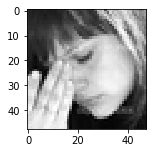

Actual label:    Sad
Predicted label: Sad


In [24]:
rand_index = np.random.randint(0,val_images.shape[0])
img_rec = val_images[rand_index]
img = np.array(img_rec).reshape(1,48,48,1)
img_pred = cnn.predict(img)
img = np.asarray(img).astype('float32')
act_label = val_labels[rand_index]
pred_label = np.argmax(img_pred, axis=1)[0]

cpt = 1
pl.figure(0, figsize=(16,18))
pl.subplot(7,5,cpt)
img = array_to_img(img[0])
pl.imshow(img, cmap='gray')
pl.show()
print(f'Actual label:    {emotion_dict[act_label]}')
print(f'Predicted label: {emotion_dict[pred_label]}')